<a href="https://colab.research.google.com/github/roguetech/ML-NIDS/blob/master/Network_Instrusion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Library Import

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout, LeakyReLU
from keras.models import Model, load_model
from tensorflow.keras import Sequential

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

Import Dataset

In [2]:
training_set = pd.read_csv('https://raw.githubusercontent.com/roguetech/datasets/main/nsl-kdd/KDDTrain%2B.txt')
test_set = pd.read_csv('https://raw.githubusercontent.com/roguetech/datasets/main/nsl-kdd/KDDTest%2B.txt')

Format Data

Adding columns to the training and test datasets

In [3]:
columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
'num_access_files', 'num_outbound_cmds', 'is_host_login',
'is_guest_login', 'count', 'srv_count', 'serror_rate',
'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate', 'attack_type', 'difficulty_level']

training_set.columns = columns
test_set.columns = columns

In [4]:
training_set

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,difficulty_level
0,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,19,0.0,0.0,1.0,1.0,0.16,0.06,0.00,255,19,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,neptune,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125967,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,184,25,1.0,1.0,0.0,0.0,0.14,0.06,0.00,255,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20
125968,8,udp,private,SF,105,145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal,21
125969,0,tcp,smtp,SF,2231,384,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal,18
125970,0,tcp,klogin,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,144,8,1.0,1.0,0.0,0.0,0.06,0.05,0.00,255,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20


Looking at Particular columns

In [5]:
training_set.iloc[:, [31,34]]

,dst_host_count,dst_host_diff_srv_rate
0,255,0.60
1,255,0.05
2,30,0.00
3,255,0.00
4,255,0.07
...,...,...
125967,255,0.06
125968,255,0.01
125969,255,0.06
125970,255,0.05


Explorary Data Analysis

In [6]:
training_set.shape

(125972, 43)

Picking out a single attack for testing

In [180]:
attack_nepture = training_set.iloc[[1]]

attack_nepture_columns = attack_nepture.select_dtypes(include='number').columns
attack_nepture = attack_nepture.select_dtypes(include='number')

In [181]:
attack_nepture_columns

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
       'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'difficulty_level'],
      dtype='object')

Looking at Attack Types

In [9]:
training_set['attack_type'].unique()

array(['normal', 'neptune', 'warezclient', 'ipsweep', 'portsweep',
       'teardrop', 'nmap', 'satan', 'smurf', 'pod', 'back',
       'guess_passwd', 'ftp_write', 'multihop', 'rootkit',
       'buffer_overflow', 'imap', 'warezmaster', 'phf', 'land',
       'loadmodule', 'spy', 'perl'], dtype=object)

Looking at features for ftp_write

FTP Write Attack
Radosavac, Svetlana & Baras, John. (2003). Detection and Classification of Network Intrusions Using Hidden Markov Models 1.  page 63

In [11]:
ftp_write_attack = training_set[training_set['attack_type'] == 'ftp_write']

In [12]:
ftp_write_attack[:1]

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,difficulty_level
2293,32,tcp,ftp,SF,104,449,0,0,0,2,0,1,0,0,0,0,1,0,1,0,0,1,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,ftp_write,7


Looking at the Test Set

In [13]:
test_set

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,difficulty_level
0,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.00,1.0,1.0,0.01,0.06,0.00,255,1,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00,neptune,21
1,2,tcp,ftp_data,SF,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,134,86,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,normal,21
2,0,icmp,eco_i,SF,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.00,0.0,0.0,1.00,0.00,1.00,3,57,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00,saint,15
3,1,tcp,telnet,RSTO,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0.0,0.12,1.0,0.5,1.00,0.00,0.75,29,86,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71,mscan,11
4,0,tcp,http,SF,267,14515,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,4,0.0,0.00,0.0,0.0,1.00,0.00,0.00,155,255,1.00,0.00,0.01,0.03,0.01,0.0,0.00,0.00,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22538,0,tcp,smtp,SF,794,333,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,100,141,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00,normal,21
22539,0,tcp,http,SF,317,938,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,11,0.0,0.00,0.0,0.0,1.00,0.00,0.18,197,255,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00,normal,21
22540,0,tcp,http,SF,54540,8314,0,0,0,2,0,1,1,0,0,0,0,0,0,0,0,0,5,10,0.0,0.00,0.0,0.0,1.00,0.00,0.20,255,255,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07,back,15
22541,0,udp,domain_u,SF,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,6,0.0,0.00,0.0,0.0,1.00,0.00,0.33,255,252,0.99,0.01,0.00,0.00,0.00,0.0,0.00,0.00,normal,21


Looking at the Different Protocol, Service and Flag types

In [14]:
training_set.protocol_type.unique()

array(['udp', 'tcp', 'icmp'], dtype=object)

In [15]:
training_set.service.unique()

array(['other', 'private', 'http', 'remote_job', 'ftp_data', 'name',
       'netbios_ns', 'eco_i', 'mtp', 'telnet', 'finger', 'domain_u',
       'supdup', 'uucp_path', 'Z39_50', 'smtp', 'csnet_ns', 'uucp',
       'netbios_dgm', 'urp_i', 'auth', 'domain', 'ftp', 'bgp', 'ldap',
       'ecr_i', 'gopher', 'vmnet', 'systat', 'http_443', 'efs', 'whois',
       'imap4', 'iso_tsap', 'echo', 'klogin', 'link', 'sunrpc', 'login',
       'kshell', 'sql_net', 'time', 'hostnames', 'exec', 'ntp_u',
       'discard', 'nntp', 'courier', 'ctf', 'ssh', 'daytime', 'shell',
       'netstat', 'pop_3', 'nnsp', 'IRC', 'pop_2', 'printer', 'tim_i',
       'pm_dump', 'red_i', 'netbios_ssn', 'rje', 'X11', 'urh_i',
       'http_8001', 'aol', 'http_2784', 'tftp_u', 'harvest'], dtype=object)

In [16]:
len(training_set.service.unique())

70

In [17]:
training_set.flag.unique()

array(['SF', 'S0', 'REJ', 'RSTR', 'SH', 'RSTO', 'S1', 'RSTOS0', 'S3',
       'S2', 'OTH'], dtype=object)

In [18]:
len(training_set.flag.unique())

11

### **Encoding non numerical Labels**

Conducting One Hot Encoding on categorical features

In [19]:
categorical_features_headings = ['protocol_type','service','flag']

categorical_features = training_set[categorical_features_headings]

categorical_features = pd.get_dummies(categorical_features,columns=categorical_features_headings)
categorical_features.head()

,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,...,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [20]:
len(categorical_features.columns)

84

## Data Normalization

Converting Attack Types to numerical values using one hot encoding

In [21]:
binary_labels = pd.DataFrame(training_set.attack_type.map(lambda x:'normal' if x=='normal' else 'abnormal'))
binary_labels

,attack_type
0,normal
1,abnormal
2,normal
3,normal
4,abnormal
...,...
125967,abnormal
125968,normal
125969,normal
125970,abnormal


In [22]:
binary_labels = pd.get_dummies(binary_labels)
binary_labels

,attack_type_abnormal,attack_type_normal
0,0,1
1,1,0
2,0,1
3,0,1
4,1,0
...,...,...
125967,1,0
125968,0,1
125969,0,1
125970,1,0


Below, Numerical Features and Categorical Features were defined and then Numerical features were normalized between 0 and 1. The categorical features are split into individual features using get dummies and transformed to one hot encoding

In [23]:
numeric_col = training_set.select_dtypes(include='number').columns

In [24]:
training_set_num = training_set.select_dtypes(include='number')

In [25]:
numeric_col

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
       'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'difficulty_level'],
      dtype='object')

In [26]:
numeric_features_columns = training_set.select_dtypes(include='number').columns
numeric_features = training_set.select_dtypes(include='number')

scalar = MinMaxScaler()
scalar.fit(numeric_features)
scaled = scalar.transform(numeric_features)

pd.set_option('display.max_columns', None)
numeric_features = pd.DataFrame(scaled, columns=numeric_features_columns)
pd.DataFrame(scaled, columns=numeric_features_columns)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,difficulty_level
0,0.000000,1.057999e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025440,0.001957,0.0,0.0,0.0,0.0,0.08,0.15,0.00,1.000000,0.003922,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0.714286
1,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.240705,0.011742,1.0,1.0,0.0,0.0,0.05,0.07,0.00,1.000000,0.101961,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0.904762
2,0.000000,1.681203e-07,6.223962e-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009785,0.009785,0.2,0.2,0.0,0.0,1.00,0.00,0.00,0.117647,1.000000,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1.000000
3,0.000000,1.442067e-07,3.206260e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058708,0.062622,0.0,0.0,0.0,0.0,1.00,0.00,0.09,1.000000,1.000000,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.000000
4,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.236791,0.037182,0.0,0.0,1.0,1.0,0.16,0.06,0.00,1.000000,0.074510,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125967,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.360078,0.048924,1.0,1.0,0.0,0.0,0.14,0.06,0.00,1.000000,0.098039,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,0.952381
125968,0.000186,7.608895e-08,1.106923e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003914,0.003914,0.0,0.0,0.0,0.0,1.00,0.00,0.00,1.000000,0.956863,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,1.000000
125969,0.000000,1.616709e-06,2.931438e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.001957,0.0,0.0,0.0,0.0,1.00,0.00,0.00,1.000000,0.117647,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,0.857143
125970,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.281800,0.015656,1.0,1.0,0.0,0.0,0.06,0.05,0.00,1.000000,0.031373,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0.952381


In [27]:
#numeric_features.iloc[:,[113,114]]

Save normalization

In [28]:
#from pickle import dump, load
#dump(scalar, open('scaler.pkl', 'wb'))

In [29]:
#from google.colab import files
#files.download('scaler.pkl') 

In [30]:
#scaler = load(open('scaler.pkl', 'rb'))

In [31]:
#attack_nepture.shape

In [32]:
#attack_nepture = scaler.transform(attack_nepture)
#attack_nepture = pd.DataFrame(attack_nepture, columns=attack_nepture_columns)
#attack_nepture

Testing Scalar

In [33]:
duration = numeric_features['duration']
duration
numeric_features['duration']

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
            ...   
125967    0.000000
125968    0.000186
125969    0.000000
125970    0.000000
125971    0.000000
Name: duration, Length: 125972, dtype: float64

### Combining Categorical and Numerical Data

In [34]:
from sklearn.model_selection import train_test_split
duration = pd.DataFrame(numeric_features['duration'])
duration

train_X = categorical_features.join(numeric_features.drop(['duration'], axis='columns'))
train_X = duration.join(train_X)

train_X

,duration,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,difficulty_level
0,0.000000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.057999e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025440,0.001957,0.0,0.0,0.0,0.0,0.08,0.15,0.00,1.000000,0.003922,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0.714286
1,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.240705,0.011742,1.0,1.0,0.0,0.0,0.05,0.07,0.00,1.000000,0.101961,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0.904762
2,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.681203e-07,6.223962e-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009785,0.009785,0.2,0.2,0.0,0.0,1.00,0.00,0.00,0.117647,1.000000,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1.000000
3,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.442067e-07,3.206260e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058708,0.062622,0.0,0.0,0.0,0.0,1.00,0.00,0.09,1.000000,1.000000,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.000000
4,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.236791,0.037182,0.0,0.0,1.0,1.0,0.16,0.06,0.00,1.000000,0.074510,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [35]:
train_X = train_X.join(binary_labels)
train_X

,duration,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,difficulty_level,attack_type_abnormal,attack_type_normal
0,0.000000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.057999e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025440,0.001957,0.0,0.0,0.0,0.0,0.08,0.15,0.00,1.000000,0.003922,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0.714286,0,1
1,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.240705,0.011742,1.0,1.0,0.0,0.0,0.05,0.07,0.00,1.000000,0.101961,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0.904762,1,0
2,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.681203e-07,6.223962e-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009785,0.009785,0.2,0.2,0.0,0.0,1.00,0.00,0.00,0.117647,1.000000,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1.000000,0,1
3,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.442067e-07,3.206260e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058708,0.062622,0.0,0.0,0.0,0.0,1.00,0.00,0.09,1.000000,1.000000,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.000000,0,1
4,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.236791,0.037182,0.0,0.0,1.0,1.0,0.16,0.06,0.00,1.000000,0.074510,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,1.000000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [36]:
train_X.columns[0:124]

Index(['duration', 'protocol_type_icmp', 'protocol_type_tcp',
       'protocol_type_udp', 'service_IRC', 'service_X11', 'service_Z39_50',
       'service_aol', 'service_auth', 'service_bgp',
       ...
       'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
       'dst_host_serror_rate', 'dst_host_srv_serror_rate',
       'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'difficulty_level',
       'attack_type_abnormal'],
      dtype='object', length=124)

In [37]:
train_X.columns.tolist()

['duration',
 'protocol_type_icmp',
 'protocol_type_tcp',
 'protocol_type_udp',
 'service_IRC',
 'service_X11',
 'service_Z39_50',
 'service_aol',
 'service_auth',
 'service_bgp',
 'service_courier',
 'service_csnet_ns',
 'service_ctf',
 'service_daytime',
 'service_discard',
 'service_domain',
 'service_domain_u',
 'service_echo',
 'service_eco_i',
 'service_ecr_i',
 'service_efs',
 'service_exec',
 'service_finger',
 'service_ftp',
 'service_ftp_data',
 'service_gopher',
 'service_harvest',
 'service_hostnames',
 'service_http',
 'service_http_2784',
 'service_http_443',
 'service_http_8001',
 'service_imap4',
 'service_iso_tsap',
 'service_klogin',
 'service_kshell',
 'service_ldap',
 'service_link',
 'service_login',
 'service_mtp',
 'service_name',
 'service_netbios_dgm',
 'service_netbios_ns',
 'service_netbios_ssn',
 'service_netstat',
 'service_nnsp',
 'service_nntp',
 'service_ntp_u',
 'service_other',
 'service_pm_dump',
 'service_pop_2',
 'service_pop_3',
 'service_printer',

Spliting the Training set into Train and Test

In [38]:
train_X, test_X = train_test_split(train_X, test_size=0.25, random_state=42)
print("train and test size: ", len(train_X), len(test_X))

train and test size:  94479 31493


In [39]:
train_X

,duration,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,difficulty_level,attack_type_abnormal,attack_type_normal
103474,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.456560e-07,9.641682e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.017613,0.023483,0.0,0.0,0.0,0.0,1.00,0.00,0.17,0.129412,1.000000,1.00,0.00,0.03,0.02,0.00,0.00,0.00,0.0,1.000000,0,1
20983,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.376848e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000134,0.0,0.0,0.0,0.0,0.0,0.0,0.003914,0.003914,0.0,0.0,0.0,0.0,1.00,0.00,0.00,0.956863,0.031373,0.03,0.02,0.03,0.00,0.00,0.00,0.83,0.0,0.809524,0,1
103667,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5.797253e-09,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.086106,0.0,0.0,0.0,0.0,1.00,0.00,1.00,0.003922,0.294118,1.00,0.00,1.00,0.51,0.00,0.00,0.00,0.0,0.761905,1,0
83047,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.054795,0.009785,1.0,1.0,0.0,0.0,0.18,0.11,0.00,1.000000,0.019608,0.02,0.07,0.00,0.00,1.00,1.00,0.00,0.0,1.000000,1,0
58076,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5.797253e-09,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.099804,0.0,0.0,0.0,0.0,1.00,0.00,1.00,0.007843,0.619608,1.00,0.00,1.00,0.25,0.00,0.00,0.00,0.0,0.714286,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [40]:
train_X_labels = train_X['attack_type_normal']

In [41]:
test_X_labels = test_X['attack_type_normal']

In [42]:
train_X_labels

103474    1
20983     1
103667    0
83047     0
58076     0
         ..
119879    0
103694    0
860       1
15795     1
121958    1
Name: attack_type_normal, Length: 94479, dtype: uint8

In [43]:
test_X_labels

378       0
47559     0
119105    1
74411     0
68224     0
         ..
87635     1
32877     0
17242     1
118702    0
100457    1
Name: attack_type_normal, Length: 31493, dtype: uint8

In [44]:
train_X_normal = train_X.loc[train_X['attack_type_normal'] == 1]
train_X_normal
train_X_abnormal = train_X.loc[train_X['attack_type_abnormal'] == 1]
train_X_abnormal

,duration,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,difficulty_level,attack_type_abnormal,attack_type_normal
103667,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5.797253e-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.086106,0.0,0.0,0.0,0.0,1.00,0.00,1.0,0.003922,0.294118,1.00,0.00,1.00,0.51,0.0,0.0,0.0,0.0,0.761905,1,0
83047,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.054795,0.009785,1.0,1.0,0.0,0.0,0.18,0.11,0.0,1.000000,0.019608,0.02,0.07,0.00,0.00,1.0,1.0,0.0,0.0,1.000000,1,0
58076,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5.797253e-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.099804,0.0,0.0,0.0,0.0,1.00,0.00,1.0,0.007843,0.619608,1.00,0.00,1.00,0.25,0.0,0.0,0.0,0.0,0.714286,1,0
92734,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111546,0.027397,1.0,1.0,0.0,0.0,0.25,0.07,0.0,1.000000,0.239216,0.24,0.02,0.02,0.00,1.0,1.0,0.0,0.0,0.952381,1,0
12667,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,7.246566e-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041096,0.037182,0.0,0.0,0.0,0.0,0.90,0.10,0.0,1.000000,0.109804,0.11,0.22,1.00,0.00,0.0,0.0,0.0,0.0,0.714286,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [45]:
test_X

,duration,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,difficulty_level,attack_type_abnormal,attack_type_normal
378,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.328767,0.005871,1.0,1.0,0.0,0.0,0.02,0.08,0.00,1.000000,0.011765,0.01,0.08,0.00,0.00,1.00,1.0,0.00,0.0,1.000000,1,0
47559,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5.797253e-09,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.072407,0.0,0.0,0.0,0.0,1.00,0.00,1.00,0.015686,0.690196,1.00,0.00,1.00,0.25,0.00,0.0,0.00,0.0,0.714286,1,0
119105,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.775409e-07,1.931390e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019569,0.021526,0.0,0.0,0.0,0.0,1.00,0.00,0.18,1.000000,1.000000,1.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,1.000000,0,1
74411,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.215264,0.015656,0.0,0.0,1.0,1.0,0.07,0.06,0.00,1.000000,0.105882,0.11,0.07,0.00,0.00,0.00,0.0,1.00,1.0,0.904762,1,0
68224,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5.797253e-09,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.066536,0.0,0.0,0.0,0.0,1.00,0.00,1.00,0.015686,0.580392,1.00,0.00,1.00,0.25,0.00,0.0,0.00,0.0,0.761905,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [46]:
test_X.shape

(31493, 125)

In [47]:
attacks = test_X.loc[test_X['attack_type_abnormal'] == 1]

In [48]:
attacks.shape

(14773, 125)

In [49]:
test_X

,duration,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,difficulty_level,attack_type_abnormal,attack_type_normal
378,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.328767,0.005871,1.0,1.0,0.0,0.0,0.02,0.08,0.00,1.000000,0.011765,0.01,0.08,0.00,0.00,1.00,1.0,0.00,0.0,1.000000,1,0
47559,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5.797253e-09,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.072407,0.0,0.0,0.0,0.0,1.00,0.00,1.00,0.015686,0.690196,1.00,0.00,1.00,0.25,0.00,0.0,0.00,0.0,0.714286,1,0
119105,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.775409e-07,1.931390e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019569,0.021526,0.0,0.0,0.0,0.0,1.00,0.00,0.18,1.000000,1.000000,1.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,1.000000,0,1
74411,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.215264,0.015656,0.0,0.0,1.0,1.0,0.07,0.06,0.00,1.000000,0.105882,0.11,0.07,0.00,0.00,0.00,0.0,1.00,1.0,0.904762,1,0
68224,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5.797253e-09,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.066536,0.0,0.0,0.0,0.0,1.00,0.00,1.00,0.015686,0.580392,1.00,0.00,1.00,0.25,0.00,0.0,0.00,0.0,0.761905,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [50]:
test_X_normal = test_X.loc[test_X['attack_type_normal'] == 1]

In [105]:
test_X_data = test_X.drop(['attack_type_abnormal','attack_type_normal','difficulty_level'],axis=1)


Autoencoder Training

In [51]:
train_X_final = train_X_normal.drop(['attack_type_abnormal','attack_type_normal'], axis=1)
test_X_final = test_X_normal.drop(['attack_type_abnormal','attack_type_normal'],axis=1)

train_X_final = train_X_final.drop('difficulty_level', axis=1)
test_X_final = test_X_final.drop('difficulty_level', axis=1)

print(test_X_final.shape)

norm_packet = train_X_final.iloc[[1]]
print("norm_packet: ", norm_packet)

attack = train_X_abnormal.drop(['attack_type_abnormal','attack_type_normal'], axis=1)
print(attack)
attack = attack.iloc[[1]]
attack.shape

normal_packet = test_X_final.iloc[[1]]
normal_packet

(16720, 122)
norm_packet:         duration  protocol_type_icmp  protocol_type_tcp  protocol_type_udp  \
20983       0.0                   0                  1                  0   

       service_IRC  service_X11  service_Z39_50  service_aol  service_auth  \
20983            0            0               0            0             0   

       service_bgp  service_courier  service_csnet_ns  service_ctf  \
20983            0                0                 0            0   

       service_daytime  service_discard  service_domain  service_domain_u  \
20983                0                0               0                 0   

       service_echo  service_eco_i  service_ecr_i  service_efs  service_exec  \
20983             0              0              0            0             0   

       service_finger  service_ftp  service_ftp_data  service_gopher  \
20983               0            0                 1               0   

       service_harvest  service_hostnames  service_http  se

,duration,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
110212,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.623231e-07,6.229305e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046967,0.046967,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.980392,1.0,1.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0


In [52]:
attacks = attacks.drop(['attack_type_abnormal','attack_type_normal'], axis =1)

In [53]:
attacks = attacks.drop('difficulty_level',axis=1)

In [54]:
test_X_final

,duration,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
119105,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.775409e-07,1.931390e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019569,0.021526,0.0,0.0,0.0,0.0,1.0,0.0,0.18,1.000000,1.000000,1.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0
110212,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.623231e-07,6.229305e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046967,0.046967,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.980392,1.000000,1.00,0.00,0.00,0.01,0.00,0.0,0.00,0.0
108845,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.833381e-07,5.145284e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025440,0.025440,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.337255,1.000000,1.00,0.00,0.01,0.02,0.00,0.0,0.00,0.0
64020,0.127575,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.065245e-07,8.015650e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.001957,0.0,0.0,0.0,0.0,1.0,0.0,0.00,1.000000,0.003922,0.00,0.77,1.00,0.00,0.00,0.0,0.00,0.0
31006,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2.478326e-07,8.672170e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041096,0.041096,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.709804,1.000000,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [55]:
train_X_values = train_X_final.values
test_X_values = test_X_final.values

attacks_values = attacks.values

In [56]:
test_X_values.shape

(16720, 122)

In [57]:
train_X_values[10]

array([0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [58]:
test_X.columns[74:85]

Index(['flag_OTH', 'flag_REJ', 'flag_RSTO', 'flag_RSTOS0', 'flag_RSTR',
       'flag_S0', 'flag_S1', 'flag_S2', 'flag_S3', 'flag_SF', 'flag_SH'],
      dtype='object')

In [59]:
train_X.iloc[:,105].unique()

array([0.  , 1.  , 0.01, 0.25, 0.99, 0.07, 0.59, 0.04, 0.1 , 0.13, 0.2 ,
       0.5 , 0.65, 0.18, 0.8 , 0.12, 0.05, 0.24, 0.03, 0.09, 0.08, 0.95,
       0.33, 0.66, 0.16, 0.17, 0.11, 0.98, 0.21, 0.06, 0.91, 0.97, 0.73,
       0.02, 0.14, 0.19, 0.58, 0.54, 0.83, 0.22, 0.37, 0.92, 0.36, 0.29,
       0.94, 0.75, 0.89, 0.53, 0.7 , 0.96, 0.4 , 0.86, 0.57, 0.67, 0.93,
       0.64, 0.78, 0.6 , 0.88, 0.84, 0.77, 0.79, 0.43, 0.68, 0.56, 0.62,
       0.61, 0.63, 0.3 , 0.23, 0.76, 0.71, 0.69, 0.52, 0.82, 0.74, 0.15,
       0.27, 0.35, 0.55, 0.9 , 0.85, 0.81, 0.72, 0.26, 0.44, 0.51, 0.87,
       0.28])

In [60]:
test_X.iloc[:1,[87]]

,land
378,0.0


In [61]:
train_X_final.iloc[:,[119]]

,dst_host_srv_serror_rate
103474,0.00
20983,0.00
28201,0.00
119405,0.00
39223,0.01
...,...
82386,0.00
54886,0.00
860,0.00
15795,0.00


In [62]:
train_X_final.iloc[10:]

,duration,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
29747,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2.326148e-07,7.244621e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003914,0.003914,0.0,0.00,0.0,0.0,1.0,0.0,0.00,0.015686,1.000000,1.00,0.00,0.25,0.02,0.00,0.00,0.0,0.0
92774,0.000000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.065245e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009785,0.001957,0.0,0.00,0.0,0.0,0.2,0.6,0.00,1.000000,0.003922,0.00,0.35,0.75,0.00,0.00,0.00,0.0,0.0
77587,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2.731956e-07,7.615631e-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007828,0.007828,0.0,0.00,0.0,0.0,1.0,0.0,0.00,0.403922,1.000000,1.00,0.00,0.01,0.04,0.00,0.00,0.0,0.0
65613,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2.087011e-07,1.423732e-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005871,0.005871,0.0,0.00,0.0,0.0,1.0,0.0,0.00,1.000000,1.000000,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
77844,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4.783459e-06,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023483,0.046967,0.0,0.00,0.0,0.0,1.0,0.0,0.08,1.000000,0.305882,0.31,0.03,0.31,0.00,0.00,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [63]:
train_X_final.iloc[:,118].unique()

array([0.  , 0.01, 0.75, 0.06, 0.03, 0.02, 0.05, 0.67, 0.7 , 0.17, 0.33,
       0.61, 0.35, 1.  , 0.62, 0.96, 0.76, 0.6 , 0.15, 0.54, 0.31, 0.51,
       0.09, 0.89, 0.53, 0.38, 0.45, 0.84, 0.43, 0.13, 0.07, 0.04, 0.5 ,
       0.47, 0.64, 0.11, 0.82, 0.56, 0.88, 0.91, 0.39, 0.78, 0.46, 0.58,
       0.41, 0.16, 0.12, 0.23, 0.08, 0.8 , 0.72, 0.25, 0.83, 0.27, 0.2 ,
       0.81, 0.29, 0.1 , 0.95, 0.42, 0.63, 0.71, 0.14, 0.86, 0.24, 0.99,
       0.4 , 0.49, 0.55, 0.68, 0.77, 0.97, 0.73, 0.59, 0.44, 0.18, 0.9 ,
       0.92, 0.85, 0.74, 0.19, 0.93, 0.48, 0.65, 0.98, 0.52, 0.69, 0.94,
       0.57, 0.28, 0.37, 0.26, 0.22, 0.87, 0.66, 0.36, 0.32, 0.34, 0.79,
       0.21, 0.3 ])

In [64]:
test_X.iloc[:,122].unique()

array([1.        , 0.71428571, 0.9047619 , 0.76190476, 0.85714286,
       0.95238095, 0.80952381, 0.28571429, 0.57142857, 0.61904762,
       0.52380952, 0.04761905, 0.66666667, 0.14285714, 0.23809524,
       0.        , 0.47619048, 0.33333333, 0.38095238, 0.42857143,
       0.0952381 , 0.19047619])

In [65]:
attacks_values.shape

(14773, 122)

In [66]:
input_dimension = train_X_final.shape[1]
input_dimension

122

## Autoencoder Setup and Model Training

In [67]:
autoencoder_model = Sequential()
autoencoder_model.add(Dense(25 ,input_dim=input_dimension, activation='relu'))
autoencoder_model.add(Dense(3, activation='relu'))
autoencoder_model.add(Dense(25, activation='relu'))

autoencoder_model.add(Dense(input_dimension))
autoencoder_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                3075      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 78        
_________________________________________________________________
dense_2 (Dense)              (None, 25)                100       
_________________________________________________________________
dense_3 (Dense)              (None, 122)               3172      
Total params: 6,425
Trainable params: 6,425
Non-trainable params: 0
_________________________________________________________________


In [176]:
autoencoder_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
history = autoencoder_model.fit(train_X_values, train_X_values, verbose=1, epochs=100, batch_size=500, validation_data=(test_X_data.values, test_X_data.values))

Epoch 1/100
102/102 [==============================] - 1s 6ms/step - loss: 0.0021 - accuracy: 0.1950 - val_loss: 0.0250 - val_accuracy: 0.2272
Epoch 2/100
102/102 [==============================] - 0s 5ms/step - loss: 0.0020 - accuracy: 0.1983 - val_loss: 0.0251 - val_accuracy: 0.2181
Epoch 3/100
102/102 [==============================] - 0s 5ms/step - loss: 0.0020 - accuracy: 0.1803 - val_loss: 0.0250 - val_accuracy: 0.2314
Epoch 4/100
102/102 [==============================] - 0s 5ms/step - loss: 0.0020 - accuracy: 0.1900 - val_loss: 0.0251 - val_accuracy: 0.1219
Epoch 5/100
102/102 [==============================] - 0s 5ms/step - loss: 0.0020 - accuracy: 0.1933 - val_loss: 0.0252 - val_accuracy: 0.1201
Epoch 6/100
102/102 [==============================] - 0s 4ms/step - loss: 0.0020 - accuracy: 0.1843 - val_loss: 0.0250 - val_accuracy: 0.2108
Epoch 7/100
102/102 [==============================] - 0s 5ms/step - loss: 0.0020 - accuracy: 0.1865 - val_loss: 0.0252 - val_accuracy: 0.2329

Result Analysis

Plotting Training and Validation Loss

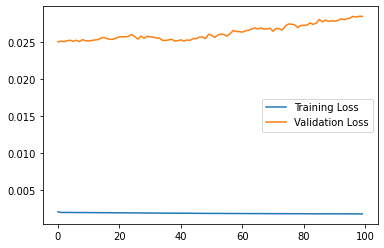

In [177]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [178]:
#Anomoly Detection
from sklearn import metrics
import matplotlib.pyplot as plt
prediction = autoencoder_model.predict(train_X_values)
score1 = tf.keras.losses.mae(prediction, train_X_values)
#score1 = np.sqrt(metrics.mean_squared_error(prediction,train_X_values))
score1

<tf.Tensor: shape=(50622,), dtype=float64, numpy=
array([0.00546646, 0.02135058, 0.00461738, ..., 0.00617098, 0.02121807,
       0.00579557])>

In [179]:
threshold = np.mean(score1) + np.std(score1)
threshold

0.02133710513888784

In [71]:
prediction2 = autoencoder_model.predict(attacks_values)
#score2 = tf.keras.losses.mae(prediction2, norm_packet.values)
score2 = tf.keras.losses.mae(prediction2, attacks_values)
#score2 = np.sqrt(metrics.mean_squared_error(prediction1,attacks.values))

score2
threshold2 = np.mean(score2) + np.std(score2)
threshold2

0.11842651672224525

In [72]:
attacks_values.shape

(14773, 122)

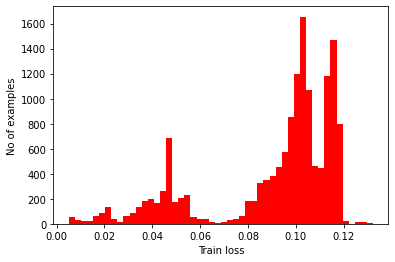

In [73]:
plt.hist(score2[None,:], bins=50, color='red')
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Test X dataset (Normal unseen values)

In [74]:
prediction3 = autoencoder_model.predict(test_X_values)
score3 = tf.keras.losses.mae(prediction3, test_X_values)

print("score length", len(score3))
threshold3 = np.mean(score3) + np.std(score3)
threshold3

score length 16720


0.023652427507753093

In [75]:
print(len(test_X))

31493


In [76]:
test_X_values.shape

(16720, 122)

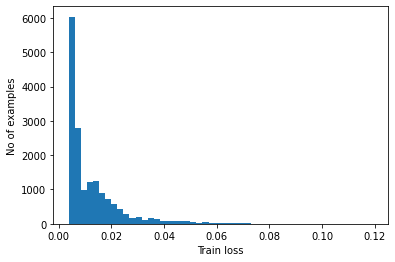

In [77]:
plt.hist(score3[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

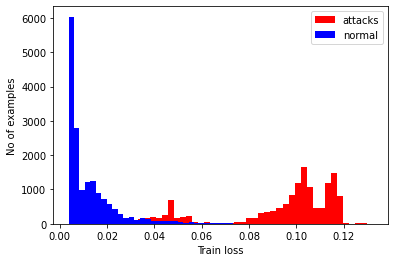

In [78]:
plt.hist(score2[None,:], bins=50, color='red', label='attacks')
plt.hist(score3[None,:], bins=50, color='blue', label='normal')
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.legend(loc='upper right')
plt.show()

In [143]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc

True Positive and False Postive of normal data when setting threshold value to 0.04

In [80]:
score3[score3<0.04]

<tf.Tensor: shape=(16096,), dtype=float64, numpy=
array([0.00494206, 0.00459579, 0.00561255, ..., 0.00640649, 0.01107049,
       0.00444906])>

In [81]:
score3[score3>0.04]

<tf.Tensor: shape=(624,), dtype=float64, numpy=
array([0.05988262, 0.07583398, 0.06530692, 0.04112338, 0.04208811,
       0.05828234, 0.0445266 , 0.06322372, 0.05575313, 0.05483985,
       0.04818989, 0.0772497 , 0.05948415, 0.04193117, 0.04539538,
       0.04517543, 0.04040816, 0.05021548, 0.04029289, 0.04361961,
       0.04507911, 0.04248954, 0.07573155, 0.06616443, 0.04031467,
       0.05588277, 0.06700317, 0.04694962, 0.04469777, 0.04663544,
       0.04526536, 0.07777051, 0.05159361, 0.04201858, 0.05676471,
       0.0430268 , 0.05585433, 0.05635469, 0.07058856, 0.05936077,
       0.04358108, 0.04953929, 0.06764707, 0.04441639, 0.06812993,
       0.04136997, 0.05257081, 0.07435157, 0.04165765, 0.11926593,
       0.04660229, 0.04934804, 0.04842747, 0.07020854, 0.04438825,
       0.0822238 , 0.04546518, 0.05295624, 0.05964383, 0.05334737,
       0.04076764, 0.04151858, 0.04568133, 0.04613972, 0.04094256,
       0.04082792, 0.05088359, 0.05312527, 0.04527663, 0.08233012,
       0.04021

Precentage of false positives

In [124]:
FP_Normal = 624 / 16096
FP_Normal

0.03876739562624255

In [125]:
TP_Normal = 1 - FP_Normal
TP_Normal

0.9612326043737575

True Positive and False Postive of Attack data when setting threshold value to 0.04

In [84]:
score2[score2<0.04]

<tf.Tensor: shape=(1063,), dtype=float64, numpy=
array([0.03716044, 0.03968321, 0.03972978, ..., 0.03453632, 0.03762801,
       0.01542177])>

In [85]:
score2[score2>0.04]

<tf.Tensor: shape=(13710,), dtype=float64, numpy=
array([0.11591406, 0.04783535, 0.09597813, ..., 0.04714855, 0.09886541,
       0.08069222])>

Precentage of false positives and True Positives

In [126]:
FP_Attack = 1063 / 13710
FP_Attack

0.07753464624361779

In [127]:
TP_Attack = 1 - FP_Attack
TP_Attack

0.9224653537563822

Accuracy

A = TP + TN / TP + TN +FP + FN

In [113]:
reconstructions = autoencoder_model(test_X_data.values)
loss = tf.keras.losses.mae(reconstructions, test_X_data.values)
prediction = tf.math.less(loss, 0.04)

print("Accuracy = {}".format(accuracy_score(test_X_labels, prediction)))

Accuracy = 0.9464325405645699


Recall
R = TP / (TP + FN) X 100%

In [114]:
print("Recall = {}".format(recall_score(test_X_labels, prediction)))

Recall = 0.9626794258373206


Precision
P = TP / (TP + FP)

In [115]:
print("Precision = {}".format(precision_score(test_X_labels, prediction)))

Precision = 0.9380500029139227


F-Measure 
F = 2PR / (P+R)

In [119]:
print("F1 = {}".format(f1_score(test_X_labels, prediction)))

F1 = 0.9502051418282712


In [129]:
cm = confusion_matrix(test_X_labels, prediction, labels=[1,0])

In [131]:
cm

array([[16096,   624],
       [ 1063, 13710]])

In [128]:
import seaborn as sn

[Text(0, 0.5, 'Normal TP')]

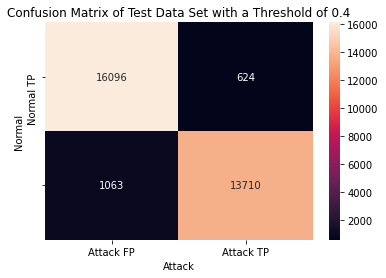

In [139]:
cm1 = sn.heatmap(cm, annot=True, fmt='g')
cm1.set_title('Confusion Matrix of Test Data Set with a Threshold of 0.4');
cm1.set_xlabel('Attack')
cm1.set_ylabel('Normal')
cm1.xaxis.set_ticklabels(['Attack FP', 'Attack TP'])
cm1.yaxis.set_ticklabels(['Normal TP'])

Save model

In [ ]:
autoencoder_model.save("autoencoder_2208.h5")

In [ ]:
#files.download('autoencoder_2208.h5') 

In [ ]:
!ls -lah

### Variantial Autoencoder